## Astronauts. ATOM, OSMO and LUNA Analysis

In [1]:
import pandas as pd
import numpy as np
import json
from math import log10, floor

from src.utils_bigquery import create_table_from_df, drop_table
from src.utils_charts import grade_boundaries_analysis, show_distribution_chart
from config import COSMOS_DATASET_NAME, COSMOS_DISTRIBUTION_TABLE_NAME

DROP_TABLES = True
CREATE_TABLES = True

In [2]:
atom_owners_initial_boundary = 1
luna_owners_initial_boundary = 1
osmo_owners_initial_boundary = 1

### Load Snapshots
#### Cosmos
You can get Cosmos snapshot from Cosmos Hub by the command:

```bash
gaiad export --for-zero-height --height=<height block> > cosmos_snapshot.json
```

The snapshot that was used is [here](https://ipfs.io/ipfs/QmeJ5yK6nBeGv3zNpbQss1Ke1fFAdGmWypT17VYPoEj55R) at the 8,241,100 block.

In [3]:
def get_coin_balance(balance: list, coin: str = 'uatom', decimals: int = 6) -> float:
    for _balance_item in balance:
        if _balance_item['denom'] == coin:
            return float(_balance_item['amount']) / 10 ** decimals
    return 0.0

### Get Balances from the Snapshot
#### Get Osmosis Liquidity volume

In [4]:
def get_osmo_prices(genesis_snapshot: json) -> [dict, pd.DataFrame]:
    pools = genesis_snapshot["app_state"]['gamm']['pools']
    pool_denoms = [pool['totalShares']['denom'] for pool in pools]
    token_denoms = [token['token']['denom'] for pool in pools for token in pool['poolAssets']]
    denoms = set(token_denoms + pool_denoms)
    price_df = pd.DataFrame(columns=denoms, index=denoms)

    osmo_price_dict = {}

    for pool in pools:
        pool_denom = pool['totalShares']['denom']
        pool_supply = int(pool['totalShares']['amount'])
        pool_assets = pool['poolAssets']
        item_denoms = [token['token']['denom'] for token in pool_assets]
        item_amounts = [int(token['token']['amount']) for token in pool_assets]

        for denom, amount in zip(item_denoms, item_amounts):
            price_df.loc[pool_denom, denom] = amount / pool_supply * 2
            price_df.loc[denom, pool_denom] = pool_supply / amount / 2
            for denom2, amount2 in zip(item_denoms, item_amounts):
                price_df.loc[denom2, denom] = amount / amount2
                price_df.loc[denom, denom2] = amount2 / amount
        try:
            osmo_index = item_denoms.index('uosmo')
            if pool_denom not in osmo_price_dict.keys():
                osmo_price_dict[pool_denom] = price_df.loc[pool_denom, item_denoms[osmo_index]]
            for denom in item_denoms:
                if denom not in osmo_price_dict.keys():
                    osmo_price_dict[denom] = price_df.loc[denom, item_denoms[osmo_index]]

        except ValueError:
            denoms_with_price = [denom for denom in item_denoms if denom in osmo_price_dict.keys()]
            try:
                denom_with_price_index = item_denoms.index(denoms_with_price[0])
                if pool_denom not in osmo_price_dict.keys():
                    osmo_price_dict[pool_denom] = price_df.loc[pool_denom, item_denoms[denom_with_price_index]] * osmo_price_dict[item_denoms[denom_with_price_index]]
                for denom in item_denoms:
                    if denom not in osmo_price_dict.keys():
                        osmo_price_dict[denom] = price_df.loc[denom, item_denoms[denom_with_price_index]] * osmo_price_dict[item_denoms[denom_with_price_index]]
            except (ValueError, KeyError):
                pass
    return osmo_price_dict, price_df

def get_liquidity_from_balance(balances: list, price_dict: dict, decimals: int = 6) -> float:
    amount = 0.0
    for _balance in balances:
        if _balance['denom'][:10] == 'gamm/pool/':
            amount += int(_balance['amount']) * price_dict[_balance['denom']]
    return amount / 10 ** decimals

def get_liquidity(genesis_snapshot: json) -> pd.DataFrame:
    osmo_price_dict, _ = get_osmo_prices(genesis_snapshot=genesis_snapshot)

    # Get balance of unstaked pools coins
    _available_balances_df = pd.DataFrame(genesis_snapshot["app_state"]['bank']['balances'])
    _available_balances_df['unstaked_liquidity'] = _available_balances_df['coins'].map(lambda x:get_liquidity_from_balance(balances=x, price_dict=osmo_price_dict))
    _available_balances_df = _available_balances_df.groupby('address')['unstaked_liquidity'].agg(sum).reset_index()

    # Get balance of staked pools coins
    _lockup_df = pd.DataFrame(genesis_snapshot["app_state"]['lockup']['locks'])
    _lockup_df['staked_liquidity'] = _lockup_df['coins'].map(lambda x:get_liquidity_from_balance(balances=x, price_dict=osmo_price_dict))
    _lockup_df.rename(columns={'owner':'address'}, inplace=True)
    _lockup_df = _lockup_df.groupby('address')['staked_liquidity'].agg(sum).reset_index()

    _liquidity_df = _available_balances_df[['address', 'unstaked_liquidity']].merge(
                        _lockup_df[['address', 'staked_liquidity']],
                        how='outer',
                        on='address').fillna(0.0)
    _liquidity_df['liquidity'] = _liquidity_df['unstaked_liquidity'] + _liquidity_df['staked_liquidity']

    return _liquidity_df[_liquidity_df.liquidity > 0]

#### Get Available, Delegated and Unbonding Balances

In [5]:
def get_balances(snapshot_url: str, coin: str = 'uatom') -> pd.DataFrame:
    with open(snapshot_url) as _f:
        _genesis_snapshot = json.load(_f)

    # Get Available balances
    available_balances_df = pd.DataFrame(_genesis_snapshot["app_state"]['bank']['balances'])
    available_balances_df.loc[:, 'available_coin'] = available_balances_df.coins.map(
        lambda x: get_coin_balance(balance=x, coin=coin))
    available_balances_df = available_balances_df[available_balances_df.available_coin != 0]
    available_balances_df['address'] = available_balances_df['address'].map(lambda x: x.lower())
    available_balances_df = available_balances_df.groupby('address')['available_coin'].agg(sum).reset_index()

    # Get Delegated balances
    delegated_balances_df = \
        pd.DataFrame(_genesis_snapshot["app_state"]['staking']['delegations'])[['delegator_address', 'shares']] \
            .rename(columns={'delegator_address': 'address'})
    delegated_balances_df['address'] = delegated_balances_df['address'].map(lambda x: x.lower())
    delegated_balances_df.loc[:, 'delegated_coin'] = delegated_balances_df['shares'].map(lambda x: float(x)/1e6)
    delegated_balances_df = delegated_balances_df.groupby('address')['delegated_coin'].agg(sum).reset_index()

    # Get Unbonding delegations
    unbonding_delegations_df = \
        pd.DataFrame([[unbonding_delegation['delegator_address'].lower(), sum([float(entry['balance'])
                      for entry in unbonding_delegation['entries']])/1e6]
                      for unbonding_delegation in _genesis_snapshot["app_state"]['staking']['unbonding_delegations']],
                     columns=['address', 'unbonding_coin']).groupby('address')['unbonding_coin'].agg(sum).reset_index()

    # Get module and pool addresses
    _module_addresses_list = \
        [item['base_account']['address'] for item in _genesis_snapshot['app_state']['auth']['accounts']
         if item['@type'] in ('/cosmos.auth.v1beta1.ModuleAccount', '/osmosis.gamm.v1beta1.Pool')]

    # Merge Available and Delegated balances
    balances_df = \
        available_balances_df[['address', 'available_coin']].merge(
            delegated_balances_df[['address', 'delegated_coin']],
            how='outer',
            on='address'
        ).merge(
            unbonding_delegations_df[['address', 'unbonding_coin']],
            how='outer',
            on='address'
        ).fillna(0)

    # Add Osmosis liquidity
    if coin=='uosmo':
        liquidity_df = get_liquidity(genesis_snapshot=_genesis_snapshot)
        balances_df = \
            balances_df.merge(
                liquidity_df,
                how='outer',
                on='address'
            ).fillna(0)
        balances_df.loc[:, 'balance_coin'] = balances_df[['available_coin', 'delegated_coin', 'unbonding_coin', 'liquidity']].sum(axis=1)
    else:
        balances_df.loc[:, 'balance_coin'] = balances_df[['available_coin', 'delegated_coin', 'unbonding_coin']].sum(axis=1)

    # Round balance and remove module, pool addresses
    balances_df.loc[:, 'balance_coin_rounded'] = \
        balances_df.balance_coin.map(lambda x: floor(x) + 0.5 if x > 1 else 0.5)
    return balances_df[~balances_df['address'].isin(_module_addresses_list)]

### Analysis of Grade Boundaries. Atom Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < ATOM Balance <= 180.0,175496,88.9
2,180.0 < ATOM Balance <= 4352.0,19832,10.1
3,4352.0 < ATOM Balance,1973,1.0


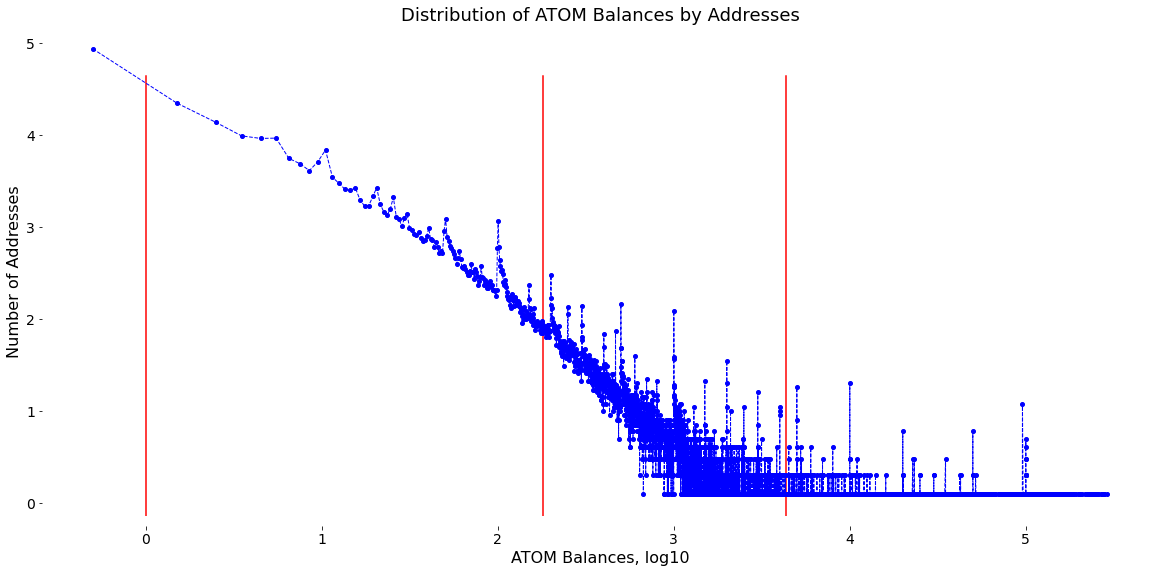

In [6]:
atom_balances_df = get_balances(snapshot_url="data/cosmos_snapshot.json", coin='uatom')
atom_balances_agg_df = \
    atom_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

atom_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=atom_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses',
        value_chart_label='ATOM Balances, log10',
        value_name='ATOM Balance',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of ATOM Balances by Addresses',
        max_show_value=300000,
        initial_boundary=atom_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Analysis of Grade Boundaries. Luna Owners

In [7]:
luna_balances_df = get_balances(snapshot_url="data/terra_snapshot.json", coin='uluna')
luna_balances_agg_df = \
   luna_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < LUNA Balance <= 568.0,97803,89.0
2,568.0 < LUNA Balance <= 12364.0,11005,10.0
3,12364.0 < LUNA Balance,1100,1.0


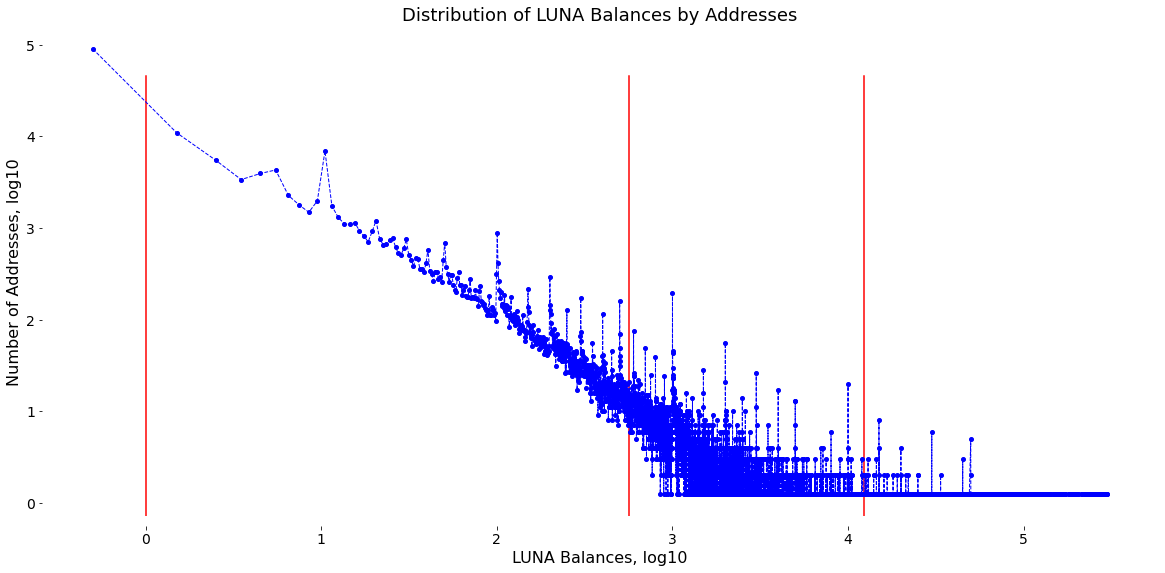

In [9]:
luna_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=luna_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses, log10',
        value_chart_label='LUNA Balances, log10',
        value_name='LUNA Balance',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of LUNA Balances by Addresses',
        max_show_value=300000,
        initial_boundary=luna_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Analysis of Grade Boundaries. Osmo Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < OSMO Balance <= 752.0,93362,89.0
2,752.0 < OSMO Balance <= 24352.0,10489,10.0
3,24352.0 < OSMO Balance,1050,1.0


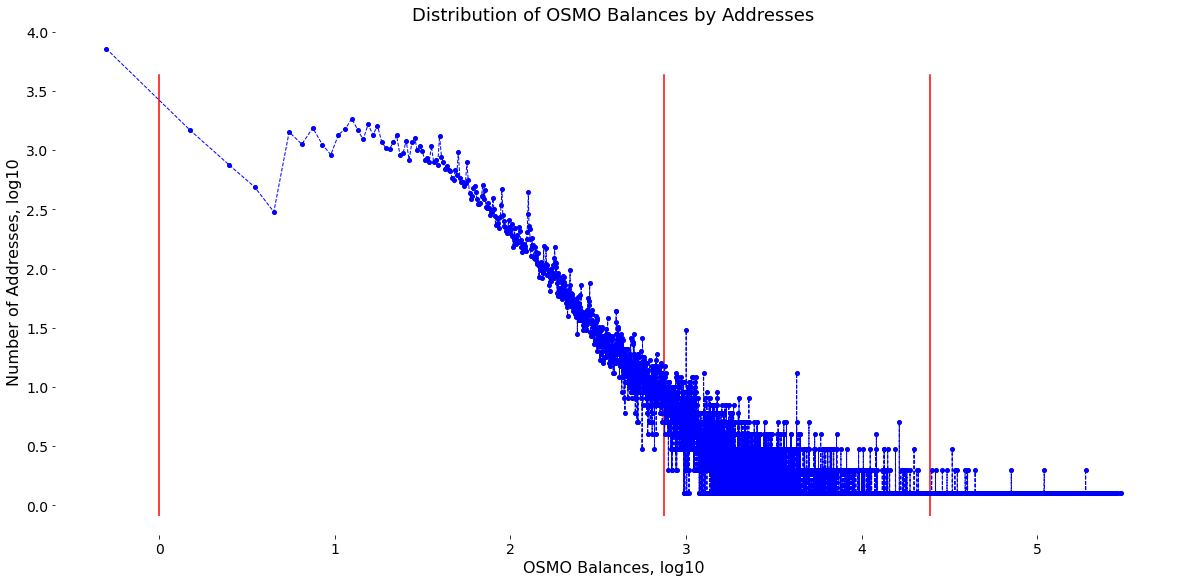

In [10]:
osmo_balances_df = get_balances(snapshot_url="data/osmosis_snapshot.json", coin='uosmo')
osmo_balances_agg_df = \
    osmo_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

osmo_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=osmo_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses, log10',
        value_chart_label='OSMO Balances, log10',
        value_name='OSMO Balance',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of OSMO Balances by Addresses',
        max_show_value=300000,
        initial_boundary=atom_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Distribution Rules

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> ATOM Balance </td>
            <td> > 1 ATOM </td>
            <td> > 180 ATOM </td>
            <td> > 4,352 ATOM </td>
        </tr>
        <tr>
            <td style="text-align: left"> OSMO Balance </td>
            <td> > 1 OSMO </td>
            <td> > 752 OSMO </td>
            <td> > 24,352 OSMO </td>
        </tr>
        <tr>
            <td style="text-align: left"> LUNA Balance </td>
            <td> > 1 LUNA </td>
            <td> > 568 LUNA </td>
            <td> > 12,364 LUNA </td>
        </tr>
    </tbody>
</table>

### Create Distribution Table

In [11]:
def set_grade(x: float, owners_boundary: list):
    if x > owners_boundary[2]:
        return 3
    elif x > owners_boundary[1]:
        return 2
    elif x > owners_boundary[0]:
        return 1
    return None

atom_balances_df.loc[:,'grade'] = atom_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=atom_owners_boundary))
osmo_balances_df.loc[:,'grade'] = osmo_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=osmo_owners_boundary))
luna_balances_df.loc[:,'grade'] = luna_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=luna_owners_boundary))

In [12]:
balances_df = pd.concat([atom_balances_df, osmo_balances_df, luna_balances_df])

In [14]:
if CREATE_TABLES:
    create_table_from_df(source_df=balances_df[['address', 'grade', 'balance_coin']],
                         table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
                         dataset_name=COSMOS_DATASET_NAME,
                         drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
               dataset_name=COSMOS_DATASET_NAME)